##### Отправляем сообщения всегда, но узел может быть не активен (блокирован) тогда сообщение ставится в очередь на узел
##### после блокировки узел считается снова свободным если очередь < L*0,5
##### число узлов 300, поток ренерируется 150 шагов, плотность сети 3,08
MultiplierThresholdToBlock <strong>L 50</strong>, FractionThresholdToUnBlock 0,5, UseOnlyIsActiveNodes True, NumberOfGenerations 150 <br>


In [1]:
#!pip install matplotlib-label-lines
import pandas
print(pandas.__version__)
#!pip install --upgrade pandas

1.1.5


In [2]:
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import os
from labellines import labelLine, labelLines
  
log_dir_path = os.path.abspath('..\\..\\')+"\\Result"
numberOfGenerations = 150;
percolation = 0.37;
nodeCount=300;

files = [
    {"filename": "Netsim-Node-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на узле на обработку", "ylabel":"Число сообщений" },
    {"filename": "Netsim-Node-Metrics-load-{log_tag}", "title": "Загрузка узлов", "ylabel":"Доля от производительности узла" },
    #{"filename": "Netsim-Connection-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на связи"},
    {"filename": "Netsim-Connection-Metrics-load-{log_tag}", "title": "Средняя загрузка связей", "ylabel":"Доля от производительности связи" },
    {"filename": "Netsim-Message-Metrics-failed-{log_tag}", "title": "Число потерянных сообщений", "ylabel":"Число сообщений" },
]

filesBlocked = [
    {"filename": "Netsim-Node-Metrics-blocked-{log_tag}", "title": "Доля блокированных узлов" },
]

filesMessage = [
    {"filename": "Netsim-Message-Metrics-{log_tag}", "title": "Число доставленных сообщений с течением времени" },

]
summBlocked = pd.DataFrame();
MessageResived = pd.DataFrame();
MessageFall = pd.DataFrame();
MessageTimeSpent = pd.DataFrame();
          
def load_csv_file(path):
    file = open(path)
    data = file.readlines()
    splitted_data = [x.split(',') for x in data]
    return splitted_data, len(splitted_data[0])


def aggeregate_line(array):
    aggregated = [sum([float(y) for y in x])/len(x) for x in array]
    return aggregated, len(aggregated)


def showStat():
    for file in files:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel(file['ylabel'])
        
        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line(data)
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label'])    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
        #labelLines(plt.gca().get_lines(), zorder=2.5)
        #lines = plt.gca().get_lines();
        #print(len(lines))
        #xvals = get_xvals(lines)
        #for idx in range(len(lines)-1):
        #    labelLine(lines[idx+1], get_x(xvals, idx, len(lines)-1), label=str(idx+1), fontsize=14, align=False)
                                   
    plt.show()
                                           
def get_xvals(lines):
    ax = lines[0].axes
    shrink_factor = 0.05
    xvals = ax.get_xlim()
    xvals_rng = xvals[1] - xvals[0]
    shrinkage = xvals_rng * shrink_factor
    xvals = (xvals[0] + shrinkage, xvals[1] - shrinkage)
    return xvals;
                                           
def get_x(xvals, i, count):
    h = (xvals[1] - xvals[0])/(count+1);
    return h*(i+1)+xvals[0];
                                           
                                           
def aggeregate_line_perc_node(array):
    aggregated = [sum([1 for y in x if float(y) > 0])/len(x) for x in array]
    return aggregated, len(aggregated)

def showStatBlocked():
    for file in filesBlocked:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля блокированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line_perc_node(data)
            summ = np.sum(aggregated)
            summBlocked.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()


def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

def load_csv_file_message(path):
    file = open(path)
    data = file.readlines()
    t = datetime(2021,6,1,1)
   
    splitted_data = [(str2bool(x.split(',')[-2]), (datetime.strptime(x.split(',')[-1], '%d.%m.%Y %H:%M:%S\n')-t).total_seconds(), float(x.split(',')[2]))  for x in data]
    df = pd.DataFrame(data=splitted_data,  columns=['Resived', 'Time' ,'TimeSpent']);
    total_count = len(df.index);
    timeSpent_avr = df['TimeSpent'].mean();
    df = df.loc[df['Resived'] == True]
    agg= df.groupby(['Time']).count()
    return agg['Resived'].to_numpy(), agg.index.get_level_values(0).to_numpy(), total_count, timeSpent_avr

def showStatMessage():
    for file in filesMessage:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel("Число сообщений")
       
        for log_tag in log_tags:
            data, line_len, all_count, timeSpent_avr = load_csv_file_message(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            summ = np.sum(data);
            fall = (all_count-summ)*100/all_count;
            print('Доставлено '+str(summ)+' Потеряно '+ "{:3.4f}".format(fall)+'% -'+log_tag['label']);
            
            MessageResived.at[quantity, log_tag['label']] = summ*100/all_count;
            MessageFall.at[quantity, log_tag['label']] = fall;
            MessageTimeSpent.at[quantity, log_tag['label']] = timeSpent_avr;
            ax.plot(line_len, data, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()


<strong>Поток Quantity 100 </strong>

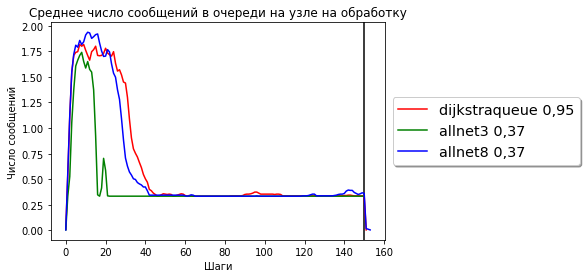

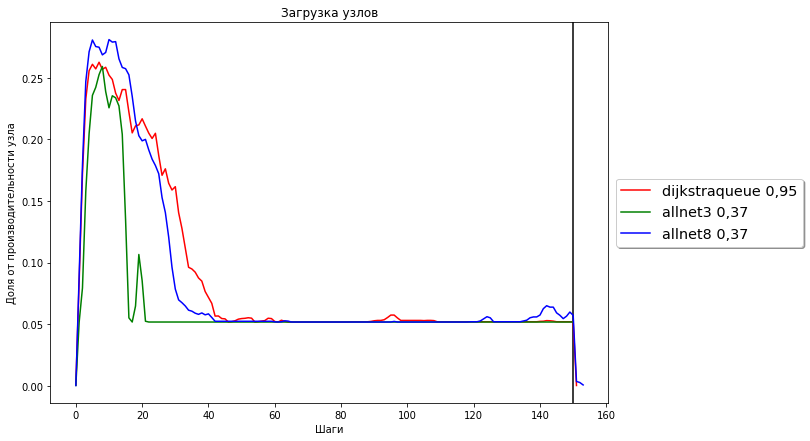

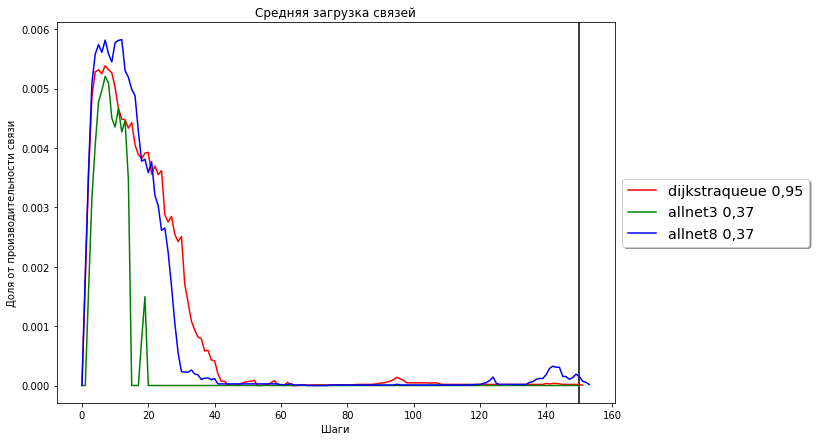

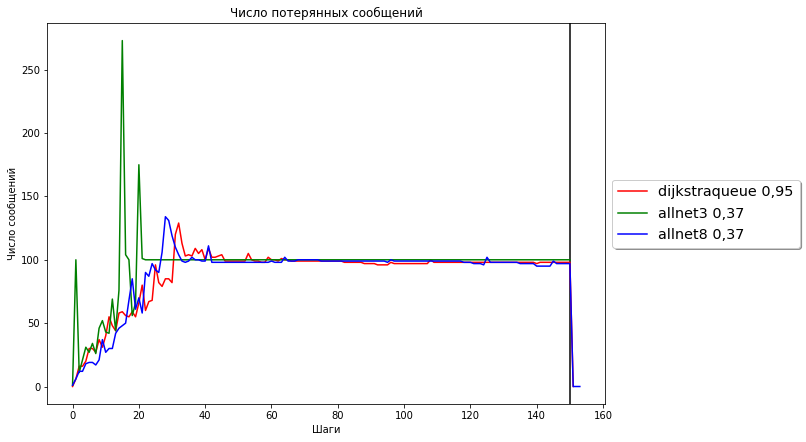

Доставлено 1477 Потеряно 90.1540% -dijkstraqueue 0,95
Доставлено 603 Потеряно 95.9803% -allnet3 0,37
Доставлено 1435 Потеряно 90.4340% -allnet8 0,37


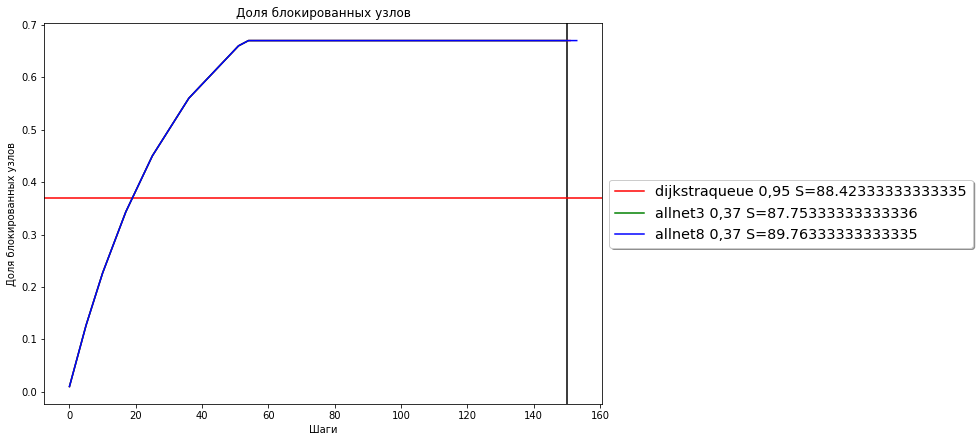

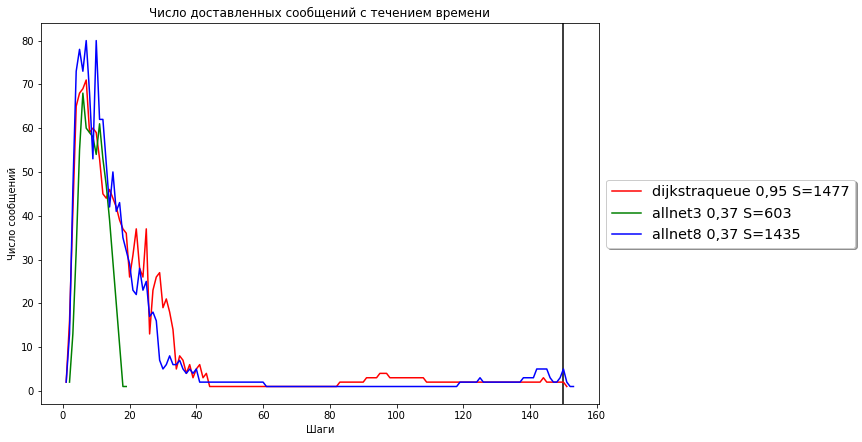

In [3]:
quantity = 100;
log_tags = [
{"tag":  "6e38c73b-2b68-4b42-ad35-65d7117e5f1a", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "e54a2b31-cd11-4ffe-8178-463aa3d2cf14", "label": "allnet3 0,37", "color": "green"},
{"tag":  "6b107958-eeea-4e63-9ca0-324a33dbb97f", "label": "allnet8 0,37", "color": "blue"},

]

showStat()
showStatBlocked();  
showStatMessage(); 


<strong>Quantity 500 </strong>

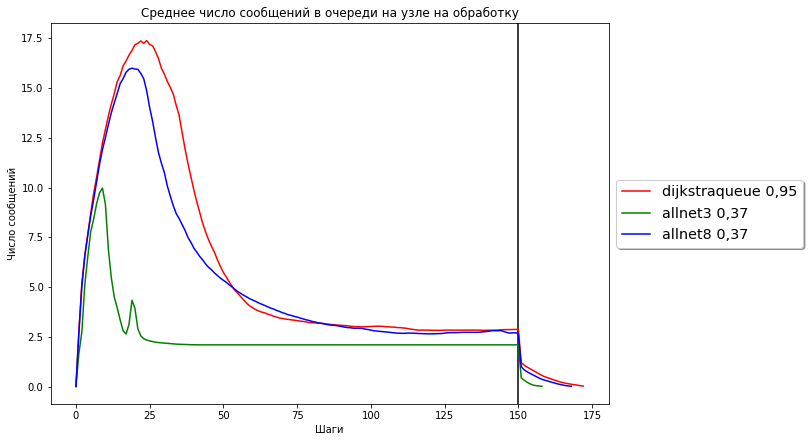

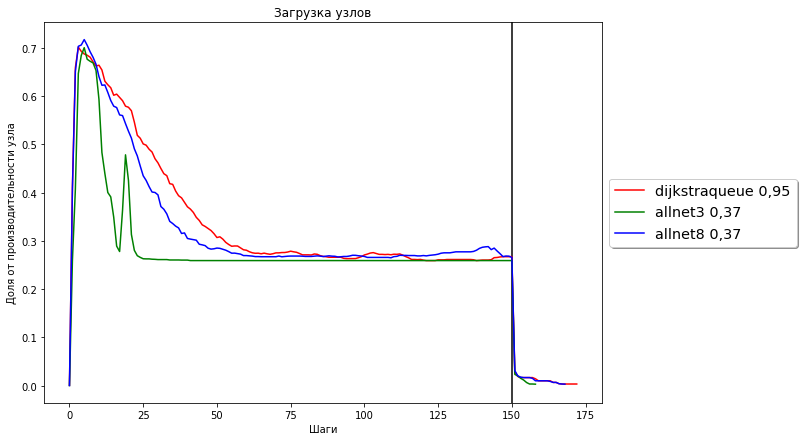

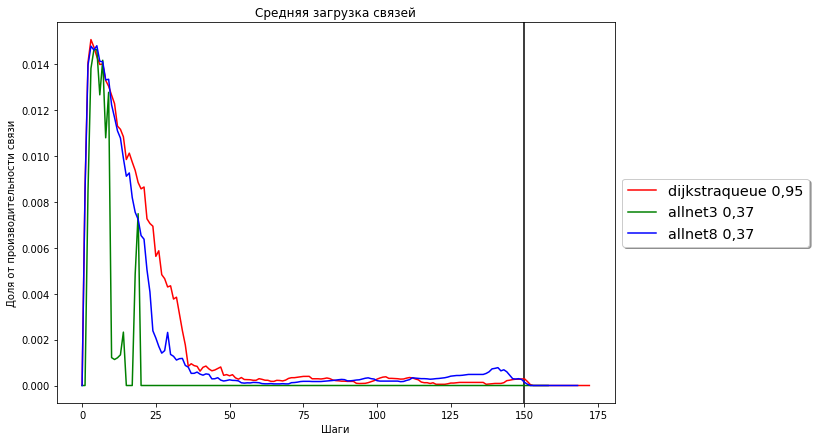

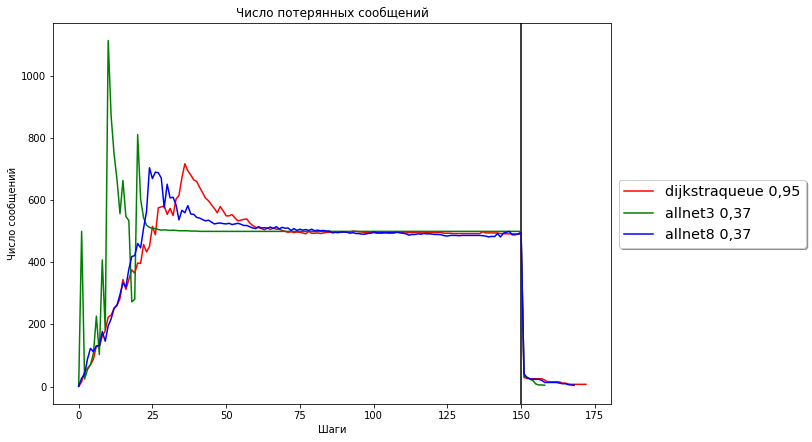

Доставлено 2960 Потеряно 96.0534% -dijkstraqueue 0,95
Доставлено 884 Потеряно 98.8213% -allnet3 0,37
Доставлено 3164 Потеряно 95.7814% -allnet8 0,37


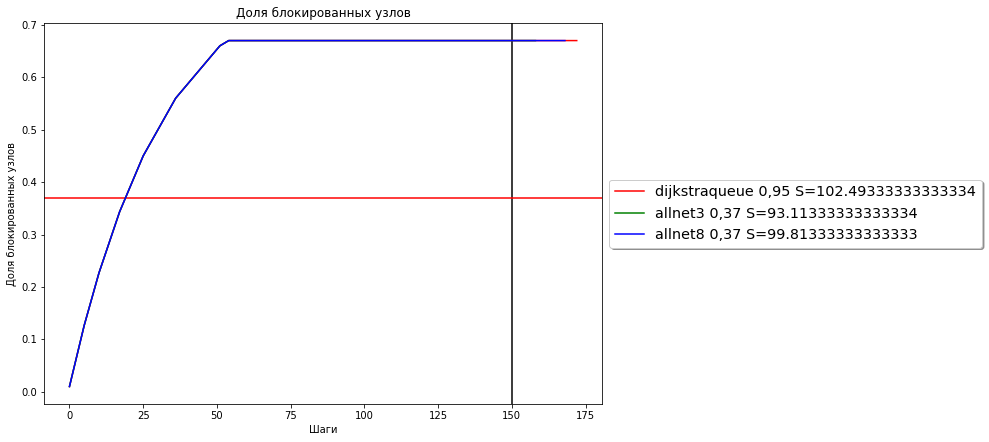

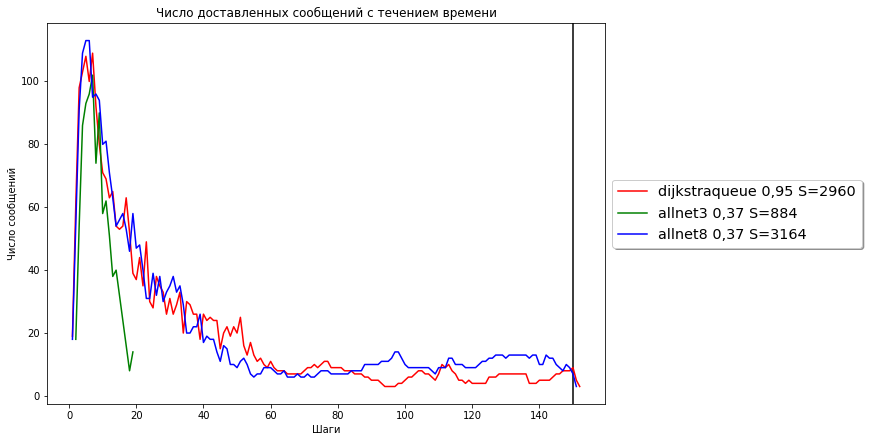

In [4]:
quantity = 500;
log_tags = [
{"tag":  "d1c24dba-ddb6-4866-b4b3-0206e49aac08", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "e6f86ccb-5908-4e12-b3f0-cc1ccab301af", "label": "allnet3 0,37", "color": "green"},
{"tag":  "5b13c8ae-27db-421d-88d4-75b7a40bd312", "label": "allnet8 0,37", "color": "blue"},

]  
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 1000 </strong>

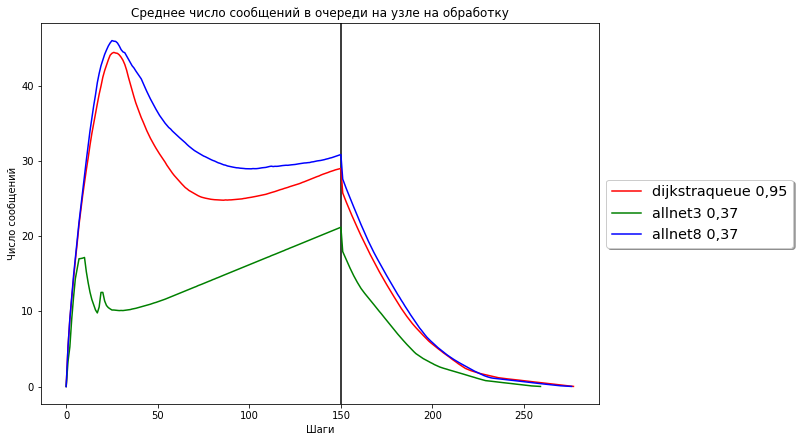

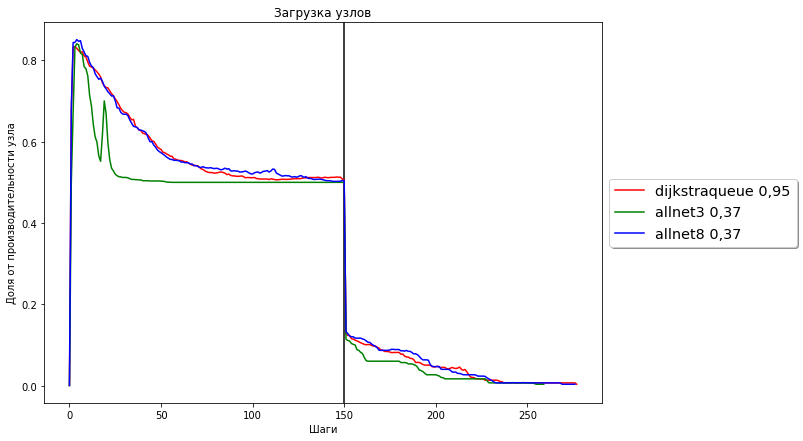

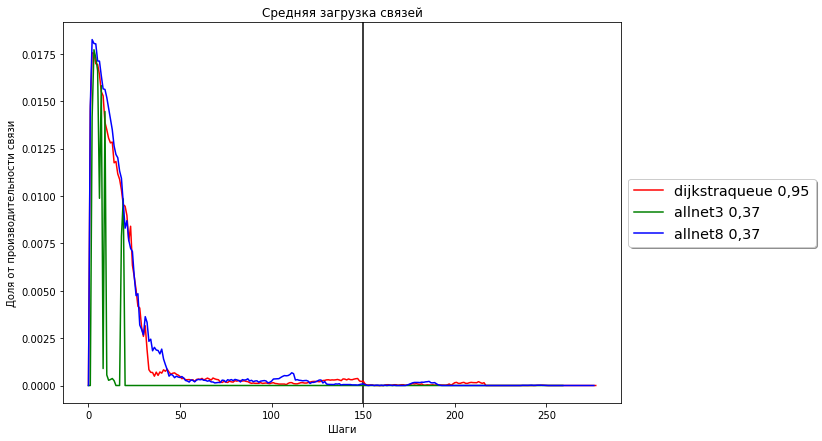

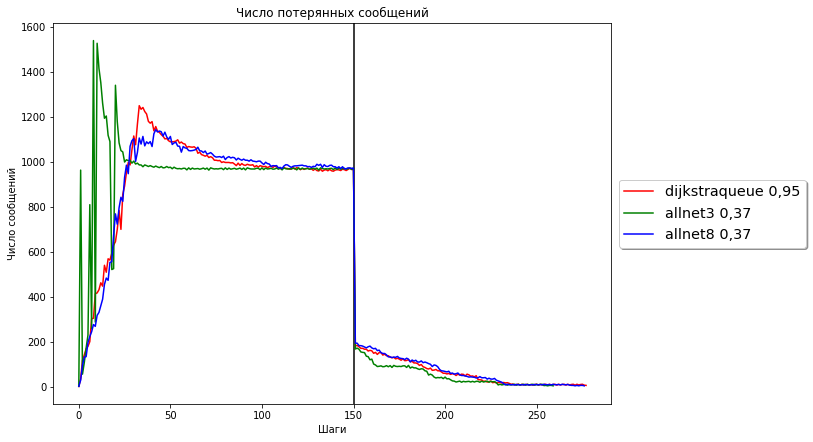

Доставлено 2903 Потеряно 98.0647% -dijkstraqueue 0,95
Доставлено 603 Потеряно 99.5980% -allnet3 0,37
Доставлено 2795 Потеряно 98.1367% -allnet8 0,37


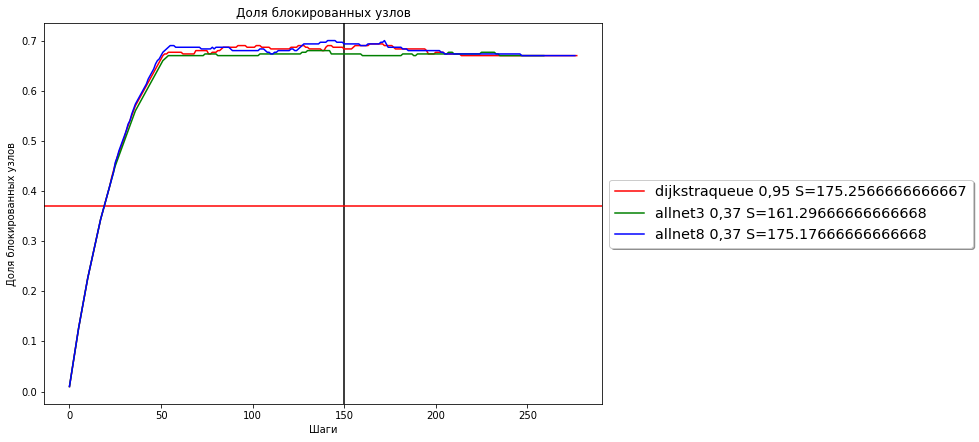

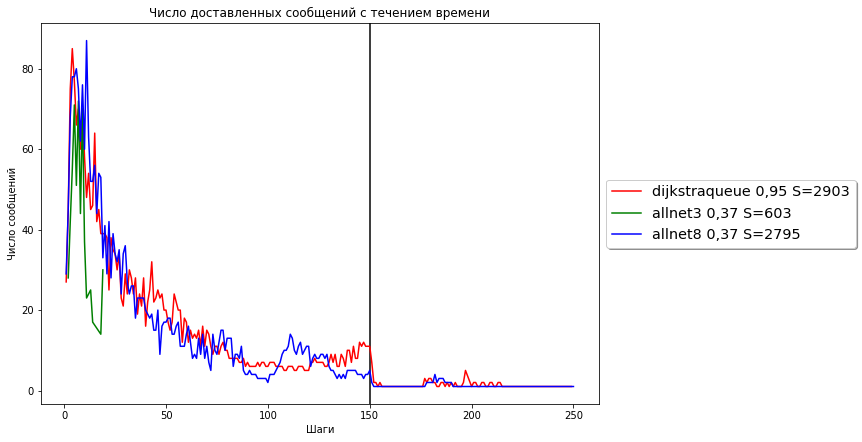

In [5]:
quantity = 1000;
log_tags = [
{"tag":  "4e2565a0-50b4-4e3e-b9a2-57cb7821753e", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "9cbc6612-eb08-4152-a00d-70728fa6ca28", "label": "allnet3 0,37", "color": "green"},
{"tag":  "ee56ac92-85c4-4dd6-a5e9-50dd61af5396", "label": "allnet8 0,37", "color": "blue"},

]  
showStat()
showStatBlocked();  
showStatMessage();

<strong>Quantity 1500 </strong>

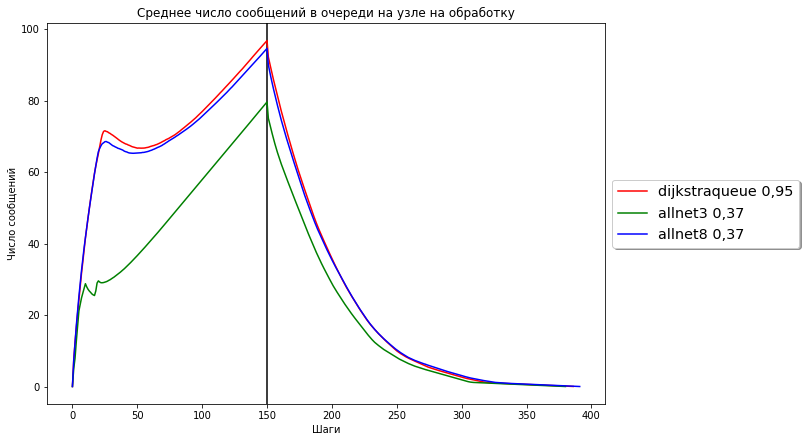

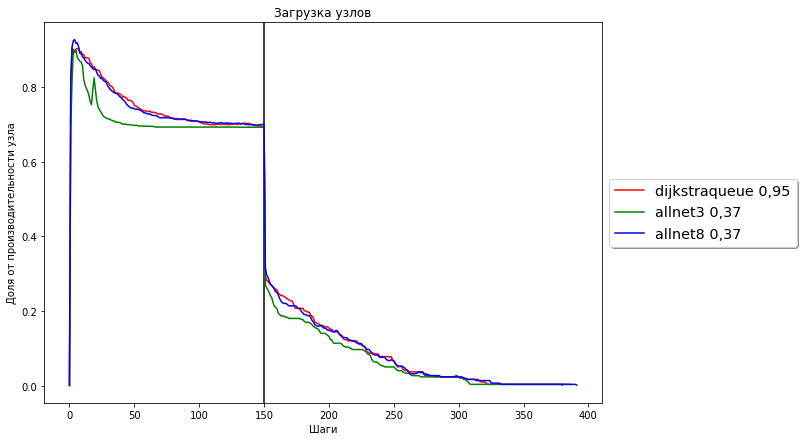

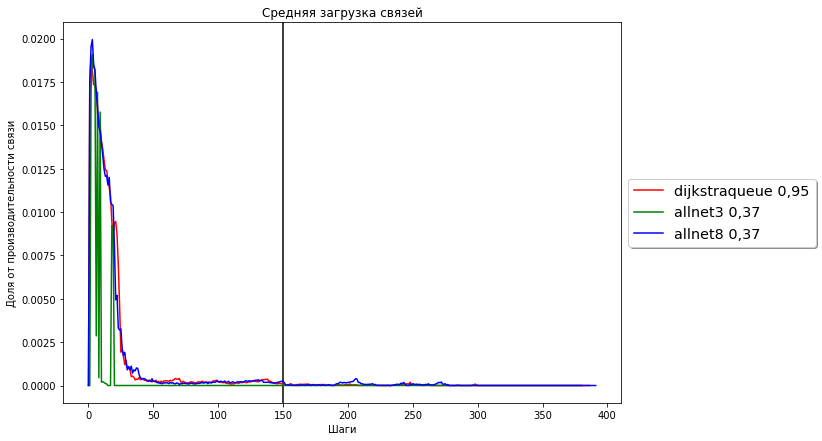

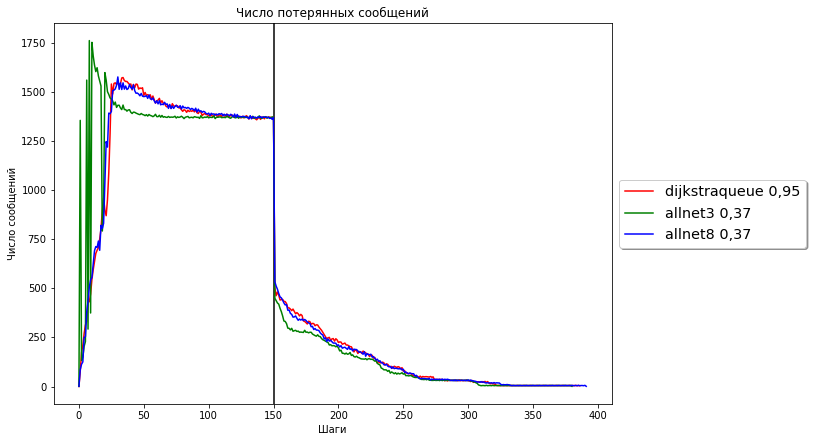

Доставлено 2716 Потеряно 98.7929% -dijkstraqueue 0,95
Доставлено 436 Потеряно 99.8062% -allnet3 0,37
Доставлено 2742 Потеряно 98.7813% -allnet8 0,37


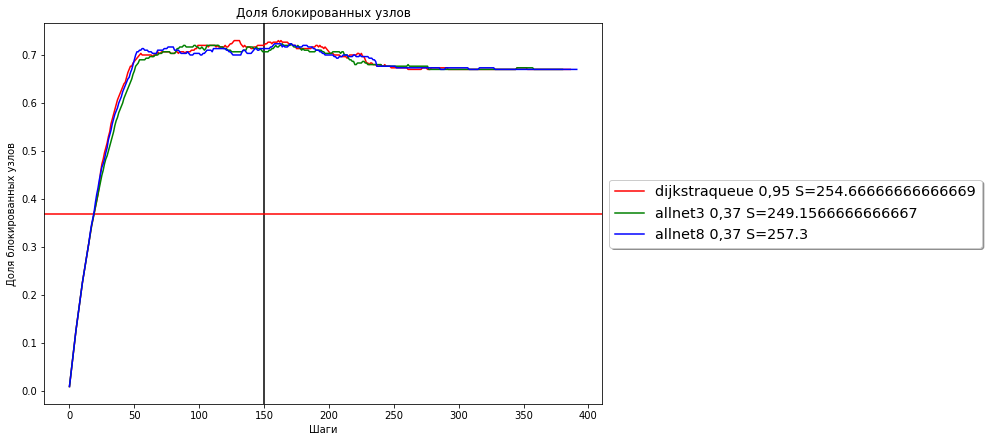

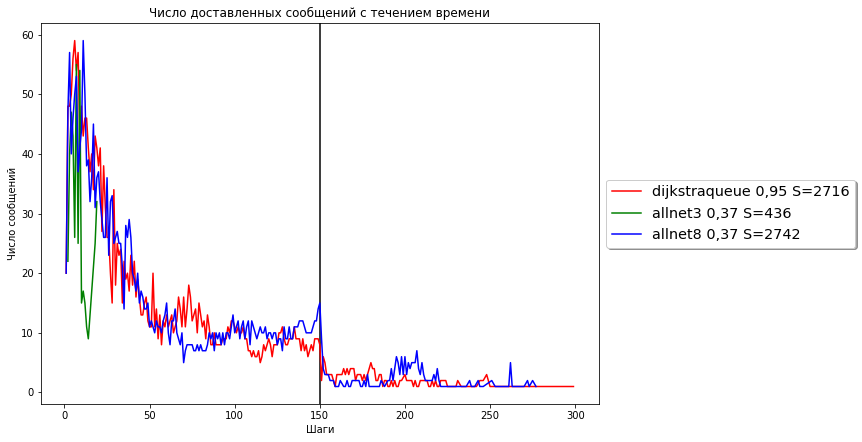

In [6]:
quantity = 1500;
log_tags = [
{"tag":  "4374db1b-97a8-4f2a-a4f5-acb91e83e5f7", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "e2e75502-12c5-4532-b105-64370e4b7d49", "label": "allnet3 0,37", "color": "green"},
{"tag":  "07e9e0b9-a99b-40ba-a112-cc445bf4859b", "label": "allnet8 0,37", "color": "blue"},

]  
showStat()
showStatBlocked();  
showStatMessage();

Доставлено 2518 Потеряно 94.4046% -dijkstraqueue 0,95
Доставлено 1077 Потеряно 97.6067% -allnet3 0,37
Доставлено 2619 Потеряно 94.1801% -allnet8 0,37


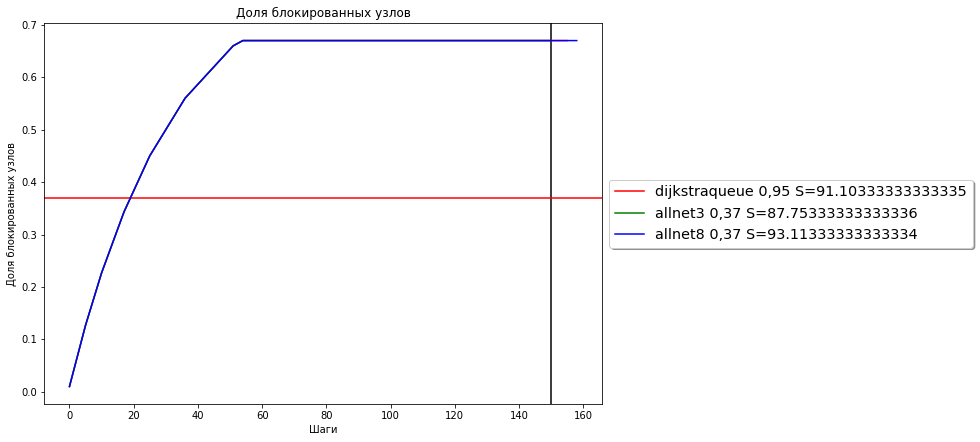

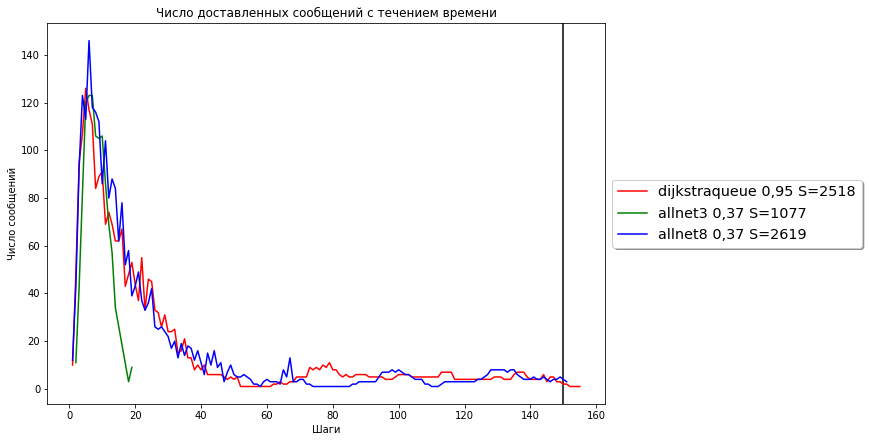

Доставлено 3273 Потеряно 96.8829% -dijkstraqueue 0,95
Доставлено 908 Потеряно 99.1352% -allnet3 0,37
Доставлено 3172 Потеряно 96.9791% -allnet8 0,37


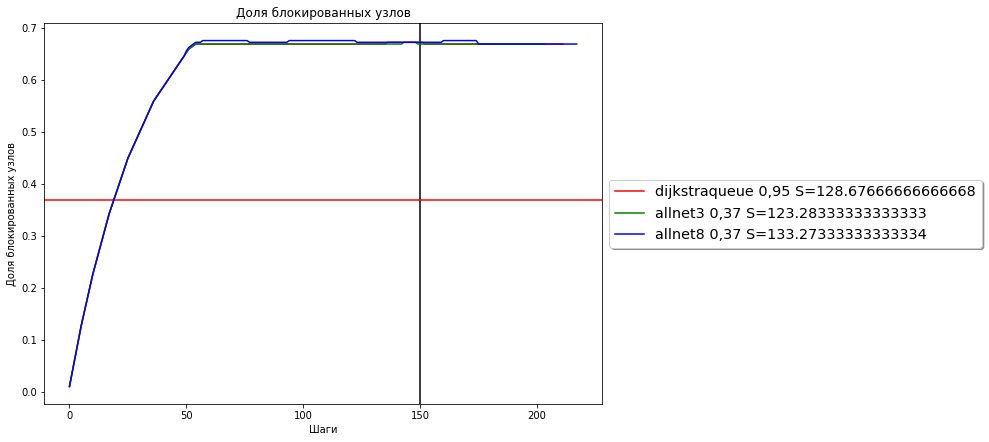

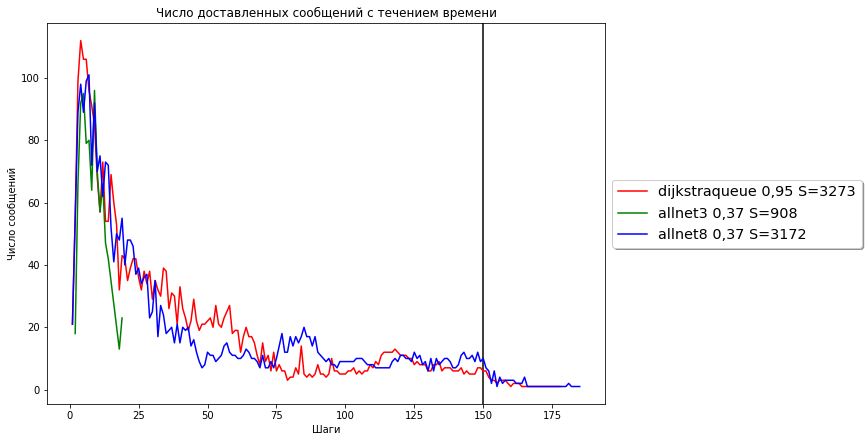

Доставлено 3097 Потеряно 97.7059% -dijkstraqueue 0,95
Доставлено 644 Потеряно 99.5230% -allnet3 0,37
Доставлено 2802 Потеряно 97.9245% -allnet8 0,37


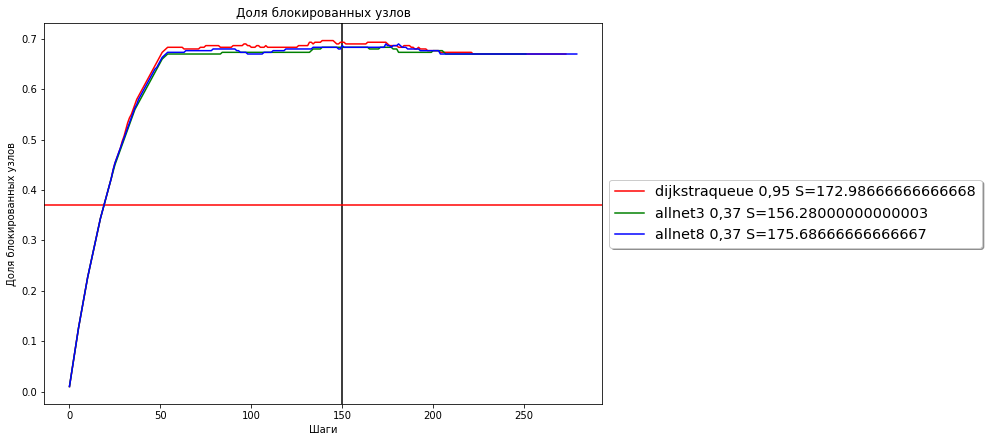

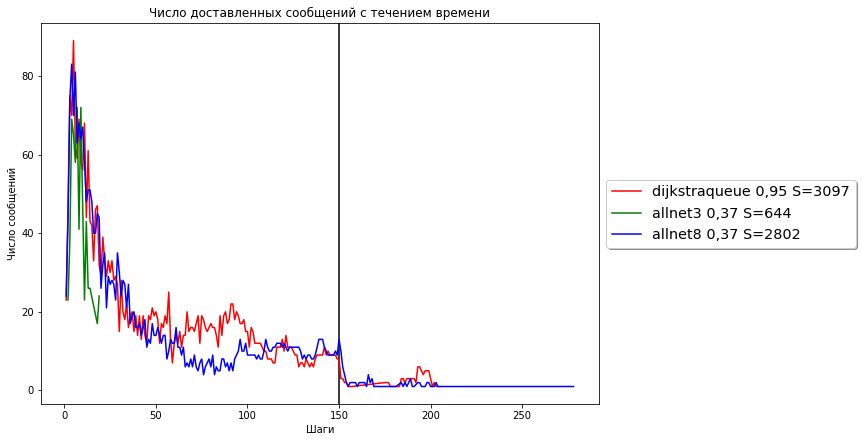

Доставлено 2798 Потеряно 98.5651% -dijkstraqueue 0,95
Доставлено 431 Потеряно 99.7790% -allnet3 0,37
Доставлено 3197 Потеряно 98.3605% -allnet8 0,37


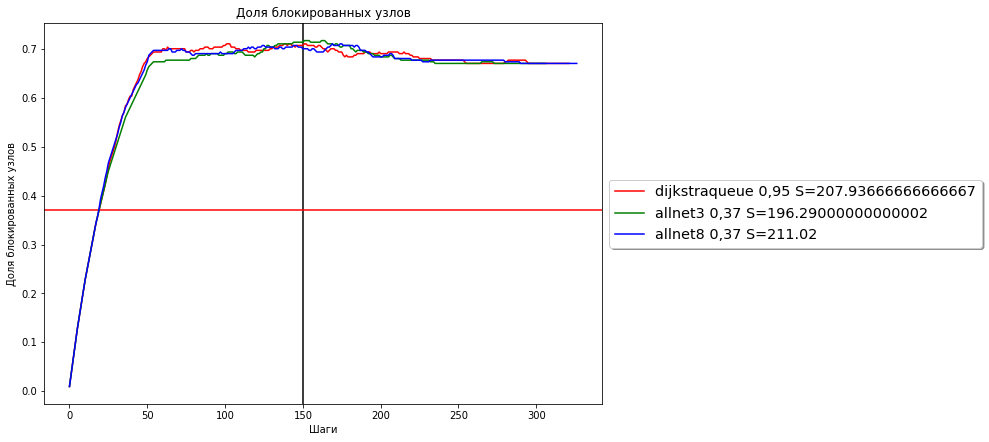

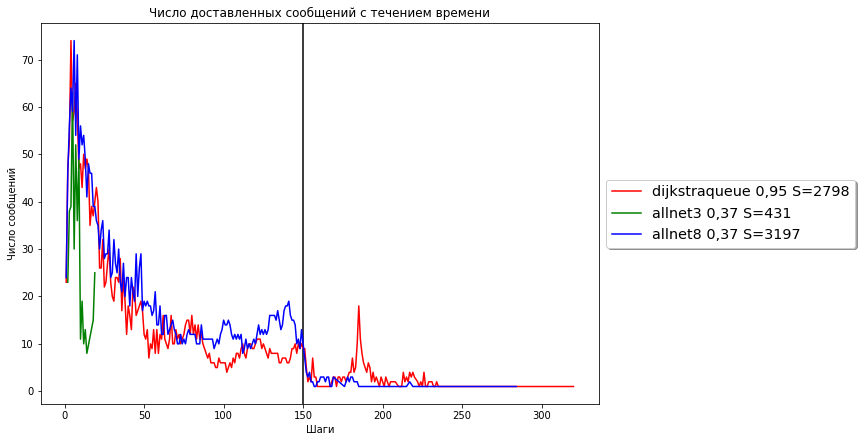

In [7]:
quantity = 300;
log_tags = [
{"tag":  "65895e05-7cad-4831-b7ca-98f142dfa1de", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "0fc07065-9323-4382-82f9-df78ef191395", "label": "allnet3 0,37", "color": "green"},
{"tag":  "51a8a58a-34a0-456b-91dc-f2e164db7c21", "label": "allnet8 0,37", "color": "blue"},

]
showStatBlocked();  
showStatMessage();
quantity = 700;
log_tags = [
{"tag":  "57a09bdf-3da5-42bf-a1e8-fc5780fc5b4a", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "f1eb9fab-77df-43f5-a724-67db10916294", "label": "allnet3 0,37", "color": "green"},
{"tag":  "2811daf0-08a8-49b7-b036-ab3c75ad145a", "label": "allnet8 0,37", "color": "blue"},

]
showStatBlocked();  
showStatMessage();
quantity = 900;
log_tags = [
{"tag":  "196603d2-73f2-4375-afc2-995d90fc3e08", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "8e205acb-5548-4bdc-a3af-51381dc7f1dd", "label": "allnet3 0,37", "color": "green"},
{"tag":  "6d8b9cb5-1c9e-43f1-bdf8-499319480881", "label": "allnet8 0,37", "color": "blue"},

]
showStatBlocked();  
showStatMessage();
quantity = 1300;
log_tags = [
{"tag":  "49fed772-5197-4a1c-b609-4d504d812d67", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "7ca72b9f-5696-4b6d-803c-d8b0cb38e1ee", "label": "allnet3 0,37", "color": "green"},
{"tag":  "ab1508be-4ac7-44cf-8331-1147f010fa09", "label": "allnet8 0,37", "color": "blue"},

]
showStatBlocked();  
showStatMessage();

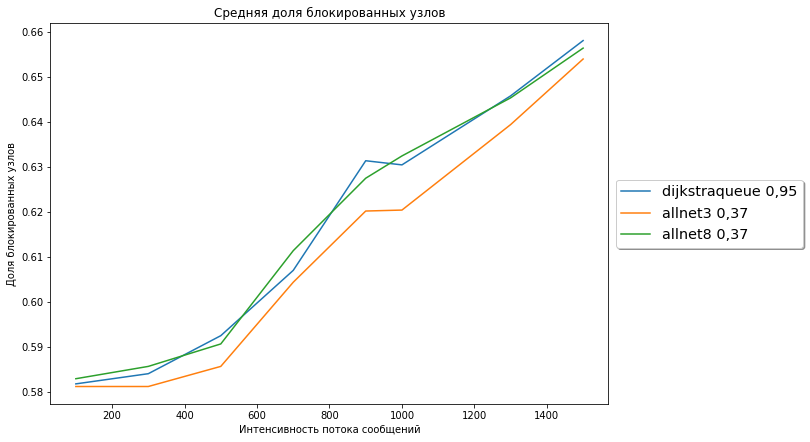

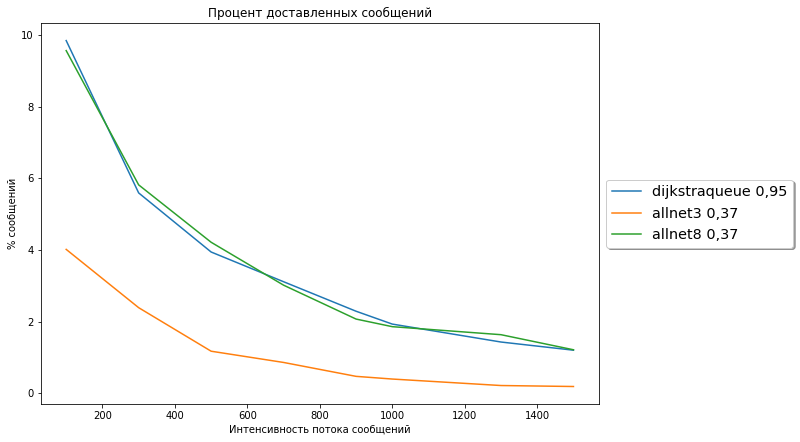

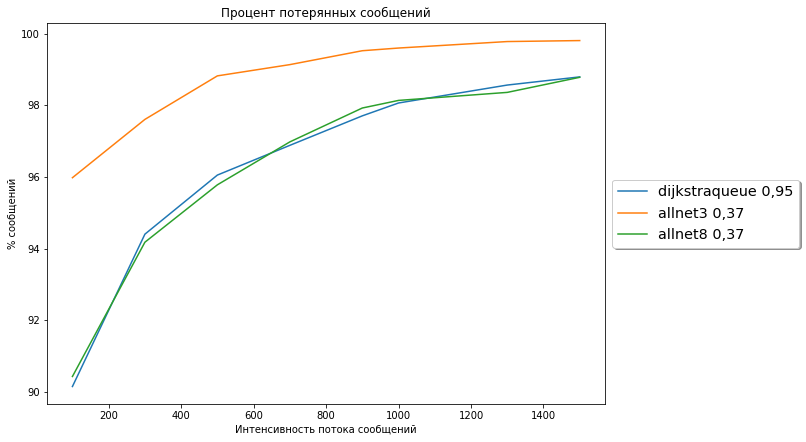

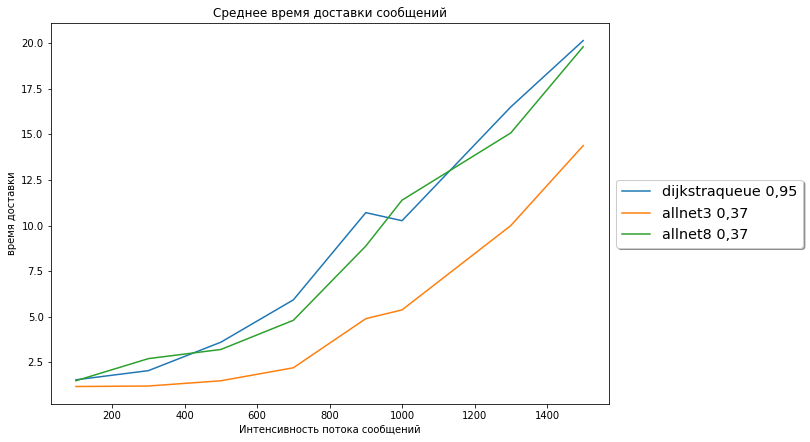

In [8]:
summBlocked.sort_index(inplace=True)
axs = summBlocked.plot()
axs.set_title("Средняя доля блокированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля блокированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageResived.sort_index(inplace=True)
axs = MessageResived.plot()
axs.set_title("Процент доставленных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageFall.sort_index(inplace=True)
axs = MessageFall.plot()
axs.set_title("Процент потерянных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageTimeSpent.sort_index(inplace=True)
axs = MessageTimeSpent.plot()
axs.set_title("Среднее время доставки сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("время доставки")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()




In [9]:
print(summBlocked.mean().to_string())
print("")
print(MessageFall.mean().to_string())
print("")
print(MessageTimeSpent.mean().to_string())


dijkstraqueue 0,95    0.616340
allnet3 0,37          0.610764
allnet8 0,37          0.616502

dijkstraqueue 0,95    96.327935
allnet3 0,37          98.781219
allnet8 0,37          96.322196

dijkstraqueue 0,95    8.841983
allnet3 0,37          5.088213
allnet8 0,37          8.419570
